# Outlier Detection

## Statistical Analysis

In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
sen_df = pd.read_csv("Stocks/sen_df_price.csv")
print(str(len(sen_df)) + " entries")
print(sen_df.columns)

4474 entries
Index(['Unnamed: 0', 'owner', 'asset_description', 'asset_type', 'type',
       'amount', 'comment', 'senator', 'ptr_link', 'id', 'min_amount',
       'max_amount', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted',
       'Error_message_x', 'transaction_date', 'ticker', 'o_c_perc', 'h_l_perc',
       'Error_message_y', '1_Week_O', '1_Week_C', '1_Week_H', '1_Week_L',
       '1_Week_V', '1_Week_A', '1_Week_o_p', '1_Week_c_p', 'Error_message',
       '1_Month_O', '1_Month_C', '1_Month_H', '1_Month_L', '1_Month_V',
       '1_Month_A', '1_Month_o_p', '1_Month_c_p'],
      dtype='object')


First we will examine the percentage returns. An important note is that the percentage is multiplied by -1 if it is a sale. That way if the stock plummets after they sell, it counts as them making that percentage. <br>  - __high_low_day__: the % change between the highest price of the transaction day and the lowest price. <br>  - __open_close_day__: the % change between the open price and the close price. <br>  - __open_open_week__: the % change between the open price of the transaction date and the open price a week later <br> - __close_close_week__: the % change between the closing price of the transaction date and the closing price a week later

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
import statistics as stat
import matplotlib.ticker as mtick

df_box = pd.DataFrame({"high_low_day": sen_df.h_l_perc,
                       "open_close_day": sen_df.o_c_perc, 
                       "open_open_week": sen_df["1_Week_o_p"], 
                       "close_close_week": sen_df["1_Week_c_p"], 
                       "open_open_month": sen_df["1_Month_o_p"], 
                       "close_close_month": sen_df['1_Month_c_p']})

sns.boxplot(x="variable", y="value", data=pd.melt(df_box))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.xticks(rotation=45)
plt.xlabel('Types of Percentages')
plt.ylabel('Percentage Change')
plt.suptitle("BoxPlot of Percentage Change Over Different Durations")
plt.show()
cols = df_box.columns
for col in cols:
    print(str(col) + " IQR: " + str("{:.4%}".format(iqr(df_box[col]))))
    print(str(col) + " Median: " + str("{:.4%}".format(stat.median(df_box[col]))))
    print(str(col) + " Mean: " + str("{:.4%}\n".format(stat.mean(df_box[col]))))

<Figure size 640x480 with 1 Axes>

high_low_day IQR: 3.9674%
high_low_day Median: 0.3715%
high_low_day Mean: 0.3350%

open_close_day IQR: 1.5568%
open_close_day Median: -0.0650%
open_close_day Mean: -0.0686%

open_open_week IQR: 3.9554%
open_open_week Median: -0.0502%
open_open_week Mean: -0.1386%

close_close_week IQR: 4.0464%
close_close_week Median: 0.0000%
close_close_week Mean: -0.0284%

open_open_month IQR: 8.2295%
open_open_month Median: -0.0602%
open_open_month Mean: 0.0863%

close_close_month IQR: 8.2950%
close_close_month Median: -0.1530%
close_close_month Mean: 0.1529%



Interestingly enough, the median is significantly lower than  mean for the month long stock duration, indicating the distribution is strongly skewed to higher returns in some measurement cases. 

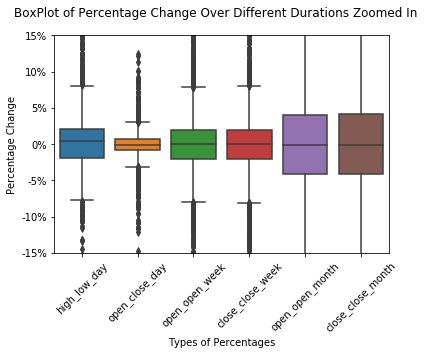

In [3]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_box))
plt.ylim([-.15, .15])
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.xticks(rotation=45)
plt.xlabel('Types of Percentages')
plt.ylabel('Percentage Change')
plt.suptitle("BoxPlot of Percentage Change Over Different Durations Zoomed In")
plt.show()

From these box plots we can see the range of transaction returns varies greatly from the mean and IQR values. One potential measure of suspicious is if a senator makes many trades in the 4th quartile range. 
<br> We can also examine the owner of the top trades for the different measures.

In [4]:
print(sen_df.nlargest(100,'o_c_perc').senator.value_counts())
print(sen_df.nlargest(100,'1_Week_C').senator.value_counts())
print(sen_df.nlargest(100,'1_Month_C').senator.value_counts())

#sen_df.nlargest(10,'')

David A Perdue , Jr    50
Pat Roberts             9
James M Inhofe          8
Susan M Collins         6
Patrick J Toomey        6
Kelly Loeffler          4
John Hoeven             4
John F Reed             3
Shelley M Capito        2
Sheldon Whitehouse      2
Jerry Moran,            2
Angus S King, Jr.       2
Thomas R Carper         1
William Cassidy         1
Name: senator, dtype: int64
Pat Roberts            19
Sheldon Whitehouse     16
Susan M Collins        12
Kelly Loeffler         12
David A Perdue , Jr    11
James M Inhofe          7
Shelley M Capito        5
Jerry Moran,            4
John F Reed             3
John Hoeven             3
Patrick J Toomey        3
Angus S King, Jr.       2
Thomas R Tillis         2
Gary C Peters           1
Name: senator, dtype: int64
Pat Roberts            19
Sheldon Whitehouse     15
Susan M Collins        12
Kelly Loeffler         12
David A Perdue , Jr    12
James M Inhofe          6
Shelley M Capito        5
Jerry Moran,            4
Patrick 

From these 3 tables, we notice that David A Perdue Jr. has many of the highest return trades on transaction day, but Pat Roberts, Sheldon Whitehouse, Susan M Collins, and Kelly Loeffler have many high return trades after a week and a month. Note that David A Perdue has the highest number of transactions by far, so his activity is perhaps not unusual. Below are each of their total transactions

In [5]:
print("David A Perdue , Jr: "+str(len(sen_df.loc[sen_df.senator == "David A Perdue , Jr"])))
print("Pat Roberts: "+str(len(sen_df.loc[sen_df.senator == "Pat Roberts"])))
print("Sheldon Whitehouse: "+str(len(sen_df.loc[sen_df.senator == "Sheldon Whitehouse"])))
print("Susan M Collins: "+str(len(sen_df.loc[sen_df.senator == "Susan M Collins"])))
print("Kelly Loeffler: "+str(len(sen_df.loc[sen_df.senator == "Kelly Loeffler"])))
     

David A Perdue , Jr: 1726
Pat Roberts: 249
Sheldon Whitehouse: 524
Susan M Collins: 389
Kelly Loeffler: 83


As you can see, everyone else's number of trades are much lower than David's. Kelly Loeffler in particular has nearly 15% of her trades in the top 2.2% of all senator trades. 

<br> We will now add a column labeling the trade's quartile to get a better overall sense of the data.

In [6]:
cols = list(["h_l_perc", "o_c_perc", "1_Week_o_p", "1_Week_c_p", "1_Month_o_p", "1_Month_c_p"])
for col in cols:
    sen_df[str(col) + "_q"] = pd.qcut(sen_df[col], 4, labels=False)
    sen_df[str(col) + "_q"] = sen_df[str(col) + "_q"] + 1
cols_q = [s + "_q" for s in cols]    

sen_df_4q = sen_df[sen_df["o_c_perc_q"] == 4]
sen_q = pd.DataFrame()
sen_q.index.name = 'Senators with 4th Quartile Trades'
sen_q['total_trans'] = sen_df.senator.value_counts()

for i in range(len(cols_q)):
    sen_df_4q = sen_df[sen_df[str(cols_q[i])] == 4]
    sen_q["n4q_" + str(cols[i])] = sen_df_4q.senator.value_counts()
    sen_q["n4q_" + str(cols[i]) + '/total_trans'] = sen_q["n4q_"+ str(cols[i])]/sen_q['total_trans']
#sen_df.head()

Here the terminalogy will be slightly confusing. Essentially we are taking the 6 types of trades from before and counting the number of times a Senator makes a trade in the top quartile, then comparing that to their overall number of trades. We would expect that on average, 25% of trades for each senator would be in the top quartile. Below is a key: <br> <br> - __n4q__: Number of 4th quartile trades. <br> - __h_l_perc__: High to Low percentage difference. o: Open, c: Close <br> - __1_Week_o_p__: 1 Week from transaction date percentage from Open to Open. <br> - __n4q_h_l_perc__: Number of times they have a 4th quartile entry in High to Low percentage. <br> - __n4q_h_l_perc/total_trans__: Fraction representing number of times they have 4th quartile entry in High to Low percentage divided by total number of transactions.

In [7]:
sen_q.head()

,total_trans,n4q_h_l_perc,n4q_h_l_perc/total_trans,n4q_o_c_perc,n4q_o_c_perc/total_trans,n4q_1_Week_o_p,n4q_1_Week_o_p/total_trans,n4q_1_Week_c_p,n4q_1_Week_c_p/total_trans,n4q_1_Month_o_p,n4q_1_Month_o_p/total_trans,n4q_1_Month_c_p,n4q_1_Month_c_p/total_trans
"David A Perdue , Jr",1726,638.0,0.369641,488.0,0.282735,503.0,0.291425,524.0,0.303592,507.0,0.293743,498.0,0.288528
Sheldon Whitehouse,524,91.0,0.173664,124.0,0.236641,118.0,0.225191,110.0,0.209924,100.0,0.190840,107.0,0.204198
Susan M Collins,389,43.0,0.110540,81.0,0.208226,82.0,0.210797,75.0,0.192802,69.0,0.177378,65.0,0.167095
Shelley M Capito,368,79.0,0.214674,65.0,0.176630,56.0,0.152174,59.0,0.160326,78.0,0.211957,79.0,0.214674
Pat Roberts,249,66.0,0.265060,64.0,0.257028,58.0,0.232932,62.0,0.248996,72.0,0.289157,78.0,0.313253


In [8]:
sen_4q = pd.DataFrame()
sen_4q['4th Q Transaction Day Percentage'] = sen_q.nlargest(10, 'n4q_o_c_perc/total_trans')['n4q_o_c_perc/total_trans']
sen_4q['total_trans'] = sen_df.senator.value_counts()
sen_4q

,4th Q Transaction Day Percentage,total_trans
Roger F Wicker,1.000000,1
Roy Blunt,1.000000,1
Michael B Enzi,1.000000,1
Ladda Tammy Duckworth,0.666667,3
Christopher A Coons,0.500000,4
Michael F Bennet,0.500000,2
Gary C Peters,0.476190,21
"Jerry Moran,",0.413793,87
Daniel S Sullivan,0.411765,17
Kelly Loeffler,0.373494,83


In [9]:
sen_4q = pd.DataFrame()
sen_4q['4th Q 1 Week Percentage'] = sen_q.nlargest(10, 'n4q_1_Week_o_p/total_trans')['n4q_1_Week_o_p/total_trans']
sen_4q['total_trans'] = sen_df.senator.value_counts()
sen_4q

,4th Q 1 Week Percentage,total_trans
John N Kennedy,1.000000,1
"Joseph Manchin, III",1.000000,1
Christopher A Coons,0.750000,4
Ladda Tammy Duckworth,0.666667,3
"Angus S King, Jr.",0.473684,19
Kelly Loeffler,0.397590,83
Thomas R Carper,0.338462,65
William Cassidy,0.328671,143
"David A Perdue , Jr",0.291425,1726
John Hoeven,0.290909,110


In [10]:
sen_4q = pd.DataFrame()
sen_4q['4th Q 1 Month Percentage'] = sen_q.nlargest(10, 'n4q_1_Month_o_p/total_trans')['n4q_1_Month_o_p/total_trans']
sen_4q['total_trans'] = sen_df.senator.value_counts()
sen_4q

,4th Q 1 Month Percentage,total_trans
Benjamin L Cardin,1.000000,1
Maria Cantwell,1.000000,1
Kelly Loeffler,0.602410,83
"Angus S King, Jr.",0.526316,19
Christopher A Coons,0.500000,4
Daniel S Sullivan,0.352941,17
"David A Perdue , Jr",0.293743,1726
William Cassidy,0.293706,143
Pat Roberts,0.289157,249
Gary C Peters,0.285714,21


Examining these 3 tables, we begin to notice names that appear multiple times and who have a high enough transaction count to not be considered lucky. This can be misleading though, as perhaps these senators just make risky trades and we are only looking at their successful trades. Further anaylysis would require looking at 1st quartile trades, trades that do worse than 75 percent of all other trades. <br> Unfortunately, due to time constraints of this project we will not be examining these names further. 

## Unsupervised Learning

With a dataset like this, it is more difficult to use supervised machine learning techniques, as there is no clear response variable. In this secion we will use several unsupervised machine learning methods in an attempt to notice patterns through clustering.

### Hierarchical Clustering

"Hierarchical clustering is more flexible than K-means and more easily accomodates non-numerical variables. It is more sensitive in discovering outlying or aberrant groups or records... Hierarchical clustering's flexibility comes with a cost, and hierarchical clustering does not scale well to large data sets with millions of records" - Practical Statistics for Data Scientists

In Python, we must convert our string columns to numerical values. Credit for the function below goes to https://pythonprogramming.net/working-with-non-numerical-data-machine-learning-tutorial/

In [11]:
import scipy.cluster.hierarchy as sch
sen_df_UL = pd.DataFrame({"High": sen_df.High, 
                       "Low": sen_df.Low, 
                       "Open": sen_df.Open, 
                       "Close": sen_df.Close, 
                       "min_amount": sen_df.min_amount, 
                       "max_amount": sen_df.max_amount, 
                       "Volume": sen_df.Volume,
                       "high_low_day": sen_df.h_l_perc,
                       "open_close_day": sen_df.o_c_perc, 
                       "open_open_week": sen_df["1_Week_o_p"], 
                       "close_close_week": sen_df["1_Week_c_p"], 
                       "open_open_month": sen_df["1_Month_o_p"], 
                       "close_close_month": sen_df['1_Month_c_p'], 
                       "Owner": sen_df.owner.astype(object), 
                       "Type": sen_df.type.astype(object), 
                       "senator": sen_df.senator.astype(object)})
sen_df_UL.convert_objects(convert_numeric=True)
sen_df_UL.fillna(0, inplace=True)

def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

sen_df_UL = handle_non_numerical_data(sen_df_UL)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


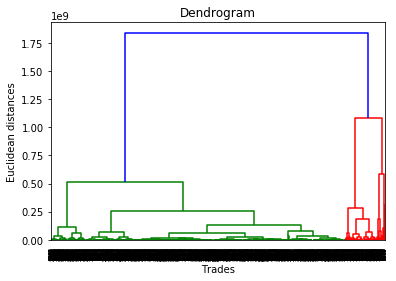

In [12]:
dendrogram = sch.dendrogram(sch.linkage(sen_df_UL, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Trades')
plt.ylabel('Euclidean distances')
plt.show()

From the dendrogram, using the ward method that minimizes varience between clusters, we can select our number of clusters. The vertical distances represent the distance/variance between clusters and in order to capture the strongest divide, we will set a threshold in a way that cuts the tallest vertical line. Marking it near the bottom of the left blue line, this will give us 3 clusters.

In [13]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(sen_df_UL)

array([1, 1, 1, ..., 1, 2, 0])

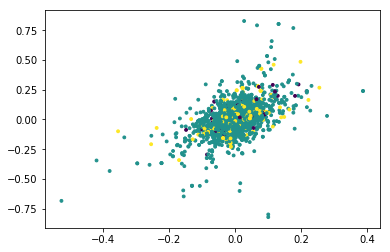

In [14]:
plt.scatter(sen_df_UL["open_open_week"], sen_df_UL["open_open_month"], c=cluster.labels_, s= 8)

### Isolation Forest

"Isolation Forest is an unsupervised learning algorithm that belongs to the ensemble decision trees family. This approach is different from all previous methods. All the previous ones were trying to find the normal region of the data then identifies anything outside of this defined region to be an outlier or anomalous.

This method works differently. It explicitly isolates anomalies instead of profiling and constructing normal points and regions by assigning a score to each data point. It takes advantage of the fact that anomalies are the minority data points and that they have attribute-values that are very different from those of normal instances. This algorithm works great with very high dimensional datasets and it proved to be a very effective way of detecting anomalies." - __[Will Badr, Sr. AI/ML Specialist @ Amazon Web Service](https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623)__

In this section we will just use the numerical columns. From this though, we can also create a covariance matrix!

In [15]:

iso_df = pd.DataFrame({"High": sen_df.High.astype(float), 
                       "Low": sen_df.Low.astype(float), 
                       "Open": sen_df.Open.astype(float), 
                       "Close": sen_df.Close.astype(float), 
                       "min_amount": sen_df.min_amount.astype(float), 
                       "max_amount": sen_df.max_amount.astype(float), 
                       "Volume": sen_df.Volume.astype(float),
                       "high_low_day": sen_df.h_l_perc.astype(float),
                       "open_close_day": sen_df.o_c_perc.astype(float), 
                       "open_open_week": sen_df["1_Week_o_p"].astype(float), 
                       "close_close_week": sen_df["1_Week_c_p"].astype(float), 
                       "open_open_month": sen_df["1_Month_o_p"].astype(float), 
                       "close_close_month": sen_df['1_Month_c_p'].astype(float)})

clf = IsolationForest(behaviour= 'new', max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(iso_df)
sen_df['Iso_score'] = preds
sus_sen = sen_df[sen_df.Iso_score == -1]
sus_sen.senator.value_counts()

sen_sus_count = pd.DataFrame({'sus_trades': sus_sen.senator.value_counts()})
sen_sus_count.index.name = 'Senators with trades marked as outliers'
sen_sus_count['total_transactions'] = sen_df.senator.value_counts()
sen_sus_count['sus_trans/total_trans'] = sen_sus_count['sus_trades']/sen_sus_count['total_transactions']
sen_sus_count.style.format({'sus_trans/total_trans': '{:,.2f}'.format})
sen_sus_count.head(10)

,sus_trades,total_transactions,sus_trans/total_trans
Senators with trades marked as outliers,,,
"David A Perdue , Jr",125,1726,0.072422
Pat Roberts,47,249,0.188755
Kelly Loeffler,46,83,0.554217
Sheldon Whitehouse,34,524,0.064885
James M Inhofe,28,162,0.172840
Susan M Collins,23,389,0.059126
John Hoeven,14,110,0.127273
Patrick J Toomey,10,136,0.073529
Shelley M Capito,8,368,0.021739


### Correlation Matrix and Dendrogram Heatmap

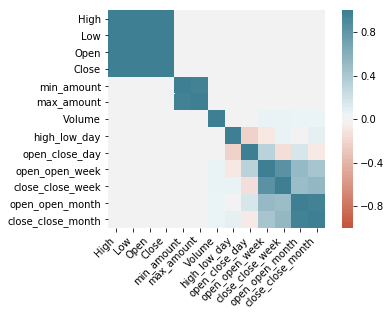

In [16]:
corr = iso_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Not very useful is it... However perhaps subsetting some of the data and using our dendrogram again will be more visually helpful.

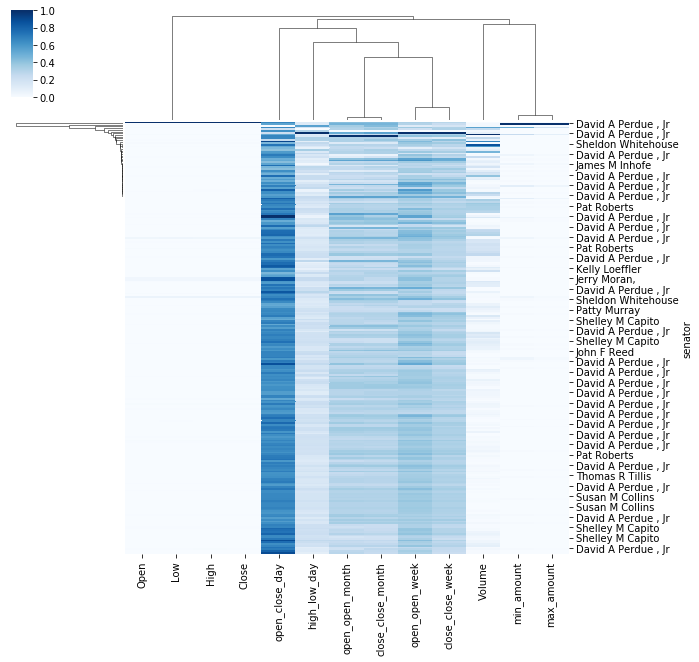

In [17]:
iso_df['senator'] = sen_df['senator']
iso_df['senator'] = sen_df['senator']
iso_df = iso_df.set_index('senator')
iso_df_sample = iso_df.sample(n=250, random_state=42)
#my_palette = dict(zip(iso_df..unique(), ["orange","yellow","brown"]))
#row_colors = df.cyl.map(my_palette)
sns.clustermap(iso_df_sample, metric="correlation", method="single", cmap="Blues", standard_scale=1)